## Intro

This project aims to produce and evaluate a neural language model, making analogies and comparing the distance between the correct word and the word predicted by the model. Due to the extensive documentation and usage, we chose to use the *gensim* library.

For pragmatism, we will follow the corpus suggestions and use the *text8* corpus, available in the *gensim* package with the sentences being iterable. The following code loads the packages that will be used and the data.

In [1]:
import gensim.downloader as api
from gensim.models import word2vec
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
import logging
from sklearn.decomposition import PCA
from matplotlib import pyplot
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

dataset = api.load("text8")
sentences = list(dataset)

Much of the success of a language model is due to good data pre-processing. This step includes techniques such as converting all characters to lowercase, removing commas and punctuation marks in general, *tokenization*, removal of *stopwords* and *lemmatization*, among others.

However, the supplied *text8* corpus already presents all lowercase characters and with a good quality, since it comes from Wikipedia. Thus, the pre-processing step applied here basically consists of removing *stop words*, which is done in the following code. A possible filtering that would help in pre-processing would be words of only 3 characters. Exploring the dataset it was possible to observe several typos for these. However, as the process would require an individual analysis of each case and the results obtained without this filtering were sufficiently satisfactory, the simplicity of the code and pragmatism were preferred.

In [2]:
sentences = [remove_stopwords(' '.join(sentences[i])).split(' ') for i in range(len(sentences))]
sentences = [[ele for ele in sub if len(ele) > 2] for sub in sentences]

# sentence example
print(sentences[0])

['anarchism', 'originated', 'term', 'abuse', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'pejorative', 'way', 'act', 'violent', 'means', 'destroy', 'organization', 'society', 'taken', 'positive', 'label', 'self', 'defined', 'anarchists', 'word', 'anarchism', 'derived', 'greek', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'political', 'philosophy', 'belief', 'rulers', 'unnecessary', 'abolished', 'differing', 'interpretations', 'means', 'anarchism', 'refers', 'related', 'social', 'movements', 'advocate', 'elimination', 'authoritarian', 'institutions', 'particularly', 'state', 'word', 'anarchy', 'anarchists', 'use', 'imply', 'chaos', 'nihilism', 'anomie', 'harmonious', 'anti', 'authoritarian', 'society', 'place', 'regarded', 'authoritarian', 'political', 'structures', 'coercive', 'economic', 'institutions', 'anarchists', 'advocate', 'social', 'relations', 'based', 'voluntary',

## Word2Vec

Once we have the data organized the way we wanted - as a list of lists of *strings* - we can train an initial Word2Vec model. This model presents a series of parameters that can be varied in order to find the model that best fits the data. First, we will separate this section into two subsections depending on the type of model we are using, CBOW or Skip-gram, defined by the **sg** parameter of the Word2Vec function, where 0 means CBOW and 1 means Skip-gram, according to the documentation.

Both models are responsible for creating Word Embeddings, which means that each word in the corpus will be represented through an N-dimensional vector, where N is the **size** parameter of the Word2Vec function. The value of N must be chosen based on the size of the corpus to be used for training. Normally, "100-dimensional" vectors are used to represent words when you have a corpus with a high number of examples for each word among tens of thousands of words.

The way Skip-gram and CBOW work and their differences lead us to the parameter **window**, responsible for determining the size of the context around the word.

- CBOW: given context, we want to predict the central word.
- Skip-gram: given a word, we want to predict the context (words around).

Note then that when we change the **window** parameter, we change the size of the input for the CBOW and the output for the Skip-gram.

To avoid the model having to deal with words that appear a few times, we can restrict Word2Vec based on the number of times a word appears in the corpus. The **min_count** parameter plays this role. It's common to want to avoid only very rare indeed words, around 1 to 5 times.

Parameters tested:
- Vector size (size) = (100, 150, 200 and 500)
- Window (window) = (5, 10, 15, 20)
- Min_count = (3, 6, 9, 12)
- Negative sampling = (0, 5)
- Ns_exponent: We do not vary this parameter, leaving it at the *default* value of the original paper.

The tested values for the parameters can be changed for the CBOW and the Skip-gram individually in the training chunks of each model in the following sections. In this original file, the parameters that presented the most interesting results for the analysis of analogies are established.

### CBOW

In [3]:
context_size = 20
min_word_count = 6
num_features = 150
num_workers = 4
negative = 0
hs = 1
expoent = 0.75
sg = 0

model_cbow = word2vec.Word2Vec(sentences, sg=sg, size=num_features, window=context_size, min_count=min_word_count, workers=num_workers,
                               sorted_vocab=1, negative=negative, seed=1, ns_exponent=expoent, hs=hs)
X_cbow = model_cbow[model_cbow.wv.vocab]

2023-06-21 22:35:26,069 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2023-06-21 22:35:26,070 : INFO : collecting all words and their counts
2023-06-21 22:35:26,071 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-06-21 22:35:27,733 : INFO : collected 252861 word types from a corpus of 8553373 raw words and 1701 sentences
2023-06-21 22:35:27,733 : INFO : Loading a fresh vocabulary
2023-06-21 22:35:28,082 : INFO : effective_min_count=6 retains 62703 unique words (24% of original 252861, drops 190158)
2023-06-21 22:35:28,082 : INFO : effective_min_count=6 leaves 8228908 word corpus (96% of original 8553373, drops 324465)
2023-06-21 22:35:28,241 : INFO : deleting the raw counts dictionary of 252861 items
2023-06-21 22:35:28,245 : INFO : sample=0.001 downsamples 3 most-common words
2023-06-21 22:35:28,246 : INFO : downsampling leaves estimated 7954488 word corpus (96.7% of prior 8228908)
2023-06-21 22:35:28,307 : INFO : co

Once the model is trained, we can obtain the words closest to a given word using the **most_similar** function, which uses cosine similarity to find the *N* most similar words. In the following example we can see that the word most similar to "queen" is "elizabeth", which shows the power of the method to find similarity between words.

In [4]:
model_cbow.wv.most_similar('queen')

2023-06-21 22:36:26,007 : INFO : precomputing L2-norms of word weight vectors


[('elizabeth', 0.6560304164886475),
 ('victoria', 0.5203901529312134),
 ('princess', 0.5191277265548706),
 ('monarch', 0.5107560157775879),
 ('prince', 0.4932408928871155),
 ('duchess', 0.4810779094696045),
 ('king', 0.4804069995880127),
 ('anne', 0.4778186082839966),
 ('consort', 0.46456122398376465),
 ('highness', 0.46176111698150635)]

With the embedding generated by the CBOW Word2Vec model, it is possible to perform operations through the vectors corresponding to the words and analyze which word the result is most similar to, that is, which word has the shortest distance to the vector found. Such a way of evaluating our model is known as solving analogies. As an example, we will use the classic `KING + WOMAN - MAN` operation. It should result in `QUEEN`, which happens for several of the models, but for the tests that showed better overall accuracy, this does not happen in the majority.

Several reasons can explain this disagreement. One of them, and the most likely one for this context, is that the word `QUEEN` and `KING` are most often used together with the name of a queen or king or a name's number (Queen Victoria II), such as Elisabeth and Isabella, which is often the result that is most similar to the classic analogy.

In [5]:
model_cbow.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=3)

[('neustria', 0.4946824014186859),
 ('aquitaine', 0.4824504256248474),
 ('crowned', 0.4665129780769348)]

The *gensim* package has a feature to evaluate the capacity (by classes, in this case) of solving analogies of a model just passing the 'questions-words.txt' file. We used the overall accuracy for the analogies as a metric of choice to determine the best model. However, some parameter combinations proved to be very effective for the *gram6-nationality-adjective* class, reaching around 70% accuracy. However, in these cases, the other classes presented results much lower than those with greater overall accuracy. Depending on the purpose of using the embeddings, you can choose another combination of parameters that seeks to maximize the accuracy of a given class.

In [6]:
similarities = model_cbow.wv.evaluate_word_analogies(datapath('./questions-words.txt'))

2023-06-21 22:36:26,317 : INFO : Evaluating word analogies for top 300000 words in the model on c:\Users\phara\anaconda3\lib\site-packages\gensim\test\test_data\./questions-words.txt
2023-06-21 22:36:27,392 : INFO : capital-common-countries: 56.3% (285/506)
2023-06-21 22:36:34,184 : INFO : capital-world: 30.1% (1009/3357)
2023-06-21 22:36:35,325 : INFO : currency: 1.7% (10/596)
2023-06-21 22:36:39,619 : INFO : city-in-state: 35.6% (758/2128)
2023-06-21 22:36:40,295 : INFO : family: 28.4% (97/342)
2023-06-21 22:36:42,148 : INFO : gram1-adjective-to-adverb: 2.5% (22/870)
2023-06-21 22:36:43,593 : INFO : gram2-opposite: 5.1% (36/702)
2023-06-21 22:36:46,297 : INFO : gram3-comparative: 19.0% (253/1332)
2023-06-21 22:36:48,207 : INFO : gram4-superlative: 5.4% (50/930)
2023-06-21 22:36:49,871 : INFO : gram5-present-participle: 11.4% (86/756)
2023-06-21 22:36:53,073 : INFO : gram6-nationality-adjective: 71.2% (1083/1521)
2023-06-21 22:36:56,256 : INFO : gram7-past-tense: 17.3% (257/1482)
2023

Note that among the existing classes in the document, the model performs better for gram6-nationality-adjective, followed by capital-common-countries and family. The worst performance was for the currency class, for which the model misses almost all examples.

A possible visual analysis of the relationship between the words comprises the use of a PCA or t-SNE to reduce the dimensionality of the vectors corresponding to each word - generated by the model. Using only two dimensions we can plot the words in a two-dimensional space and visually analyze the distance between them. The code below does exactly what is described for the words of an analogy, using PCA.

In [7]:
correct_example = list(similarities[1][0]['correct'][:2])
incorrect_example = list(similarities[1][0]['incorrect'][:2])

example = correct_example
# example = incorrect_example

foo = list(model_cbow.wv.vocab.keys())
indexes = []
for item in example:
  a,b,c,d = item
  a = foo.index(a.lower())
  b = foo.index(b.lower())
  c = foo.index(c.lower())
  d = foo.index(d.lower())
  indexes.extend((a, b, c, d))
import numpy as np
_, idx = np.unique(indexes, return_index=True)
indexes = np.array(indexes)[np.sort(idx).astype(int)]

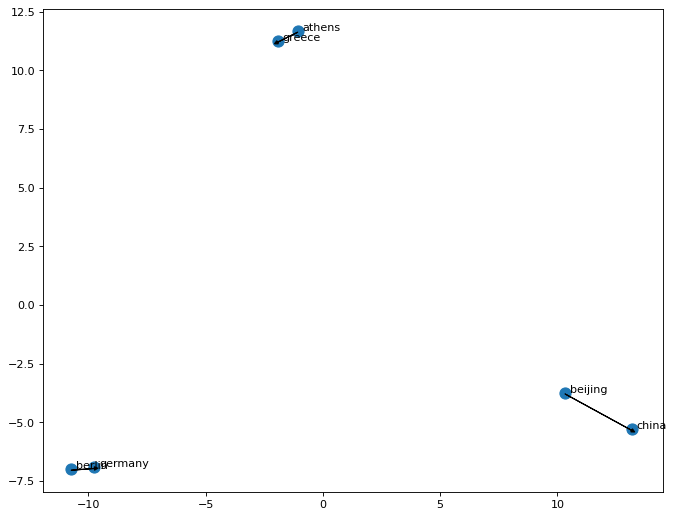

In [8]:
pca = PCA(n_components=2)
result = pca.fit_transform(X_cbow[indexes])
size = 20
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result[:, 0], result[:, 1], s=100)
words = [list(model_cbow.wv.vocab.keys())[list(indexes)[i]] for i in range(len(list(indexes)))]

if example == correct_example:
  capitals = [words[i] for i in [0,2,4]]
  countries = [words[i] for i in [1,3,5]]
  for i in range(len(capitals)):
    x = result[words.index(capitals[i]), 0]
    y = result[words.index(capitals[i]), 1]
    dx = result[words.index(countries[i]), 0] - x
    dy = result[words.index(countries[i]), 1] - y
    plt.arrow(x, y-0.05, dx, dy, head_width=0.15, head_length=0.15, fc='k', ec='k')

for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0]+0.2, result[i, 1]))
plt.show()

The plot above that the model performs well for the correct examples, establishing similar relationships for countries and their respective capitals.

### Skip-gram

Here, the routine implemented for the CBOW is replicated by changing the **sg** parameter of the Word2Vec function and, therefore, there are no comments sections.

2023-06-21 22:37:00,331 : INFO : collecting all words and their counts
2023-06-21 22:37:00,332 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-06-21 22:37:01,744 : INFO : collected 252861 word types from a corpus of 8553373 raw words and 1701 sentences
2023-06-21 22:37:01,744 : INFO : Loading a fresh vocabulary
2023-06-21 22:37:02,060 : INFO : effective_min_count=12 retains 41558 unique words (16% of original 252861, drops 211303)
2023-06-21 22:37:02,061 : INFO : effective_min_count=12 leaves 8060685 word corpus (94% of original 8553373, drops 492688)
2023-06-21 22:37:02,180 : INFO : deleting the raw counts dictionary of 252861 items
2023-06-21 22:37:02,186 : INFO : sample=0.001 downsamples 3 most-common words
2023-06-21 22:37:02,186 : INFO : downsampling leaves estimated 7784843 word corpus (96.6% of prior 8060685)
2023-06-21 22:37:02,233 : INFO : constructing a huffman tree from 41558 words
2023-06-21 22:37:03,020 : INFO : built huffman tree with maxim

QUEEN SIMILARITY:  [('elizabeth', 0.8422247171401978), ('prince', 0.7951779365539551), ('princess', 0.747859001159668), ('crown', 0.7246151566505432), ('anne', 0.7225764989852905), ('highness', 0.7091344594955444), ('consort', 0.693722128868103), ('duchess', 0.6926062107086182), ('throne', 0.6863209009170532), ('king', 0.6851376295089722)]
KING + WOMAN - MAN :  [('queen', 0.6905564069747925), ('prince', 0.6845740079879761), ('throne', 0.6647992134094238), ('sibylla', 0.6305160522460938), ('princess', 0.6237257719039917), ('heir', 0.6191746592521667), ('anjou', 0.6127957105636597), ('elizabeth', 0.6121192574501038), ('daughter', 0.6083856225013733), ('anne', 0.598404049873352)]


2023-06-21 22:40:25,755 : INFO : capital-common-countries: 61.3% (310/506)
2023-06-21 22:40:27,867 : INFO : capital-world: 48.6% (1201/2472)
2023-06-21 22:40:28,241 : INFO : currency: 9.9% (41/416)
2023-06-21 22:40:29,975 : INFO : city-in-state: 22.1% (427/1933)
2023-06-21 22:40:30,217 : INFO : family: 34.6% (94/272)
2023-06-21 22:40:30,890 : INFO : gram1-adjective-to-adverb: 10.4% (79/756)
2023-06-21 22:40:31,295 : INFO : gram2-opposite: 3.9% (18/462)
2023-06-21 22:40:32,428 : INFO : gram3-comparative: 17.4% (219/1260)
2023-06-21 22:40:33,062 : INFO : gram4-superlative: 6.5% (49/756)
2023-06-21 22:40:33,754 : INFO : gram5-present-participle: 22.9% (173/756)
2023-06-21 22:40:35,036 : INFO : gram6-nationality-adjective: 70.8% (1077/1521)
2023-06-21 22:40:36,275 : INFO : gram7-past-tense: 16.3% (241/1482)
2023-06-21 22:40:37,193 : INFO : gram8-plural: 46.7% (524/1122)
2023-06-21 22:40:37,656 : INFO : gram9-plural-verbs: 15.4% (85/552)
2023-06-21 22:40:37,657 : INFO : Quadruplets with out

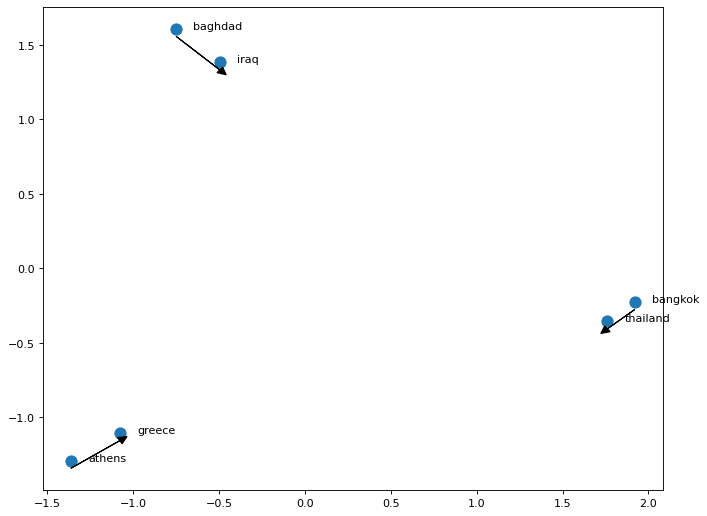

In [9]:
context_size = 15
min_word_count = 12
num_features = 100
num_workers = 4
negative = 0
hs = 1
expoent = 0.75
sg = 1

model_skipgram = word2vec.Word2Vec(sentences, sg=sg, size=num_features, window=context_size, min_count=min_word_count, workers=num_workers,
                                   sorted_vocab=1, iter=5, negative=negative, seed=1, ns_exponent=expoent, hs=hs)

X_skipgram = model_skipgram[model_skipgram.wv.vocab]

print('QUEEN SIMILARITY: ', model_skipgram.wv.most_similar('queen'))

print('KING + WOMAN - MAN : ', model_skipgram.wv.most_similar(positive=['king', 'woman'], negative=['man']))

similarities = model_skipgram.wv.evaluate_word_analogies(datapath('./questions-words.txt'))
correct_example = list(similarities[1][0]['correct'][:2])
incorrect_example = list(similarities[1][0]['incorrect'][:2])

example = correct_example
# example = incorrect_example

foo = list(model_skipgram.wv.vocab.keys())
indexes = []
for item in example:
  a,b,c,d = item
  a = foo.index(a.lower())
  b = foo.index(b.lower())
  c = foo.index(c.lower())
  d = foo.index(d.lower())
  indexes.extend((a, b, c, d))
_, idx = np.unique(indexes, return_index=True)
indexes = np.array(indexes)[np.sort(idx).astype(int)]

pca = PCA(n_components=2)
result = pca.fit_transform(X_skipgram[indexes])
size = 20
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result[:, 0], result[:, 1], s=100)
words = [list(model_skipgram.wv.vocab.keys())[list(indexes)[i]] for i in range(len(list(indexes)))]

if example == correct_example:
  capitals = [words[i] for i in [0,2,4]]
  countries = [words[i] for i in [1,3,5]]
  for i in range(len(capitals)):
    x = result[words.index(capitals[i]), 0]
    y = result[words.index(capitals[i]), 1]
    dx = result[words.index(countries[i]), 0] - x
    dy = result[words.index(countries[i]), 1] - y
    plt.arrow(x, y-0.05, dx, dy, head_width=0.05, head_length=0.05, fc='k', ec='k')

for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0]+0.1, result[i, 1]))
plt.show()

## Conclusion

Analyzing the performances of the two models and the visual analyzes presented, it is possible to observe that Skip-gram performed better than CBOW in relation to the analogy solution, reaching a higher accuracy. For specific classes - mainly for gram6-nationality-adjective - accuracy close to 80% was achieved with Skip-gram, which demonstrates Word2Vec's capacity to create embedding of words capable of representing semantic relations through vectors. In some analogies, despite being considered an error in the model evaluation, it was possible to observe that the semantic relations are still present. For example, in some cases the correct analogy has Russia as the correct answer and the model predicted USSR, which is totally acceptable.